## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
plt.rcParams["figure.figsize"] = (9,12)

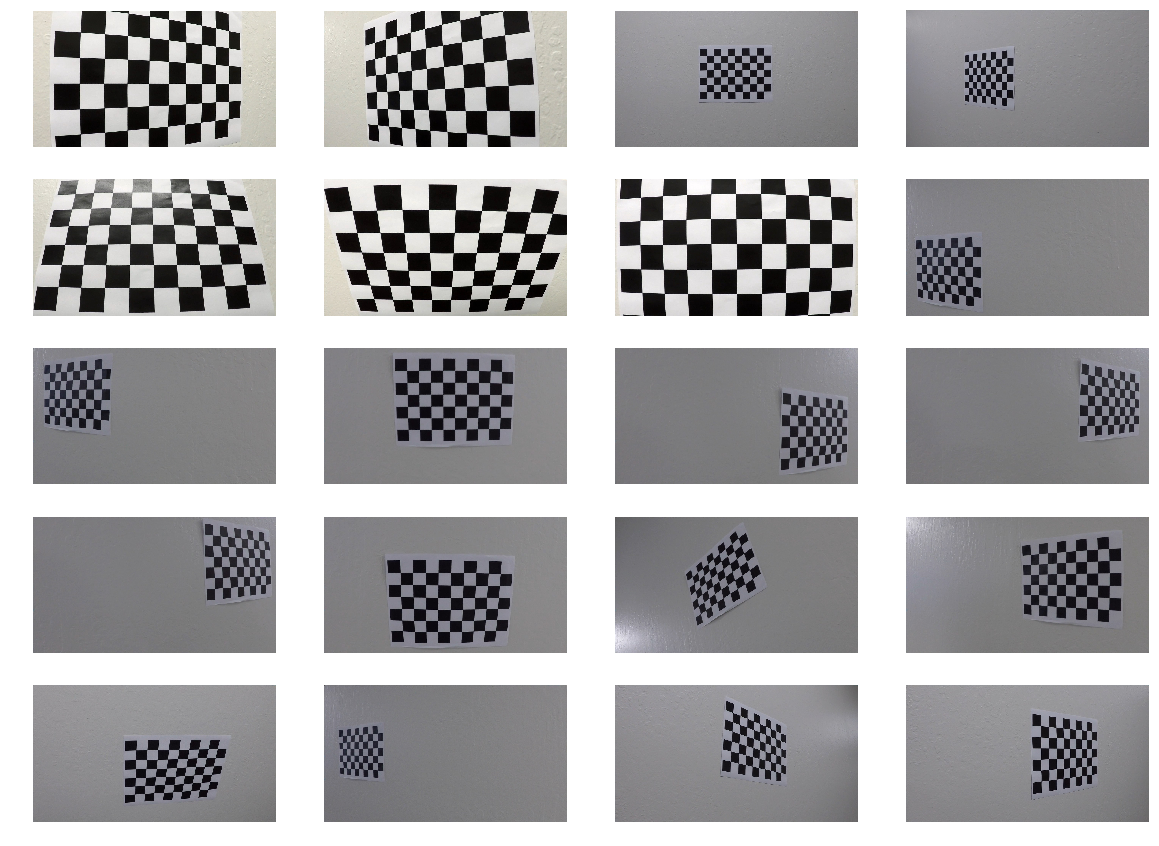

In [3]:
fnames = glob.glob('camera_cal/calibration*.jpg')

n_col = 4
n_row = int(np.ceil(len(fnames)/n_col))
f, axs = plt.subplots(n_row, n_col, figsize=(20,3*n_row))
axs = axs.ravel()
for i in range(len(axs)):
    if i < len(fnames):
        axs[i].axis('off')
        image = mpimg.imread(fnames[i])
        axs[i].imshow(image)
    else:
        f.delaxes(axs[i])

## Camera Calibration
Two main steps:
1. Use chessboard images to obtain image points and object points
2. Use OpenCV functions `cv2.calibrateCamera()` and `cv2.undistort()` to compute the calibration and undistortion.

### Image points and object points
I used OpenCV to convert the image to grayscale first, then used the functions `findChessboardCorners()` and `drawChessboardCorners()` to automatically find and draw corners in the chessboard images.

I observed that there are 9 inside corners in the row, 6 inside corners in the column, and stored them in `nx` and `ny`.

I start by preparing `object points`, which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.|

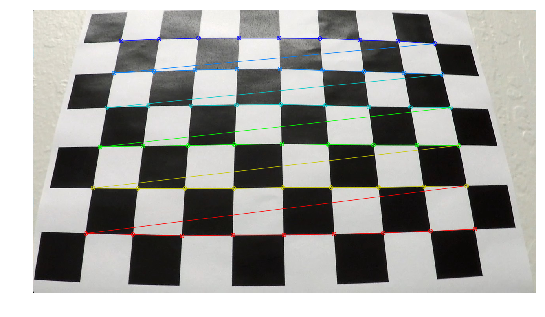

In [4]:
nx = 9
ny = 6

# Make a list of calibration images
img_index = 4
test_img = mpimg.imread(fnames[img_index])

# Convert to grayscale
gray = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(test_img, (nx, ny), corners, ret)
    plt.axis('off')
    plt.imshow(test_img)

In [5]:
def generate_points(fnames):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    for fname in sorted(fnames):
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        img_width, img_height = gray.shape[1], gray.shape[0]
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    return objpoints, imgpoints

objpoints, imgpoints = generate_points(fnames)

### Camera calibration matrix and distortion coefficient

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

In [6]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [7]:
def show_images(img1, img2, title1='Original Image', title2='New Image', fsize=30):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=fsize)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(title2, fontsize=fsize)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

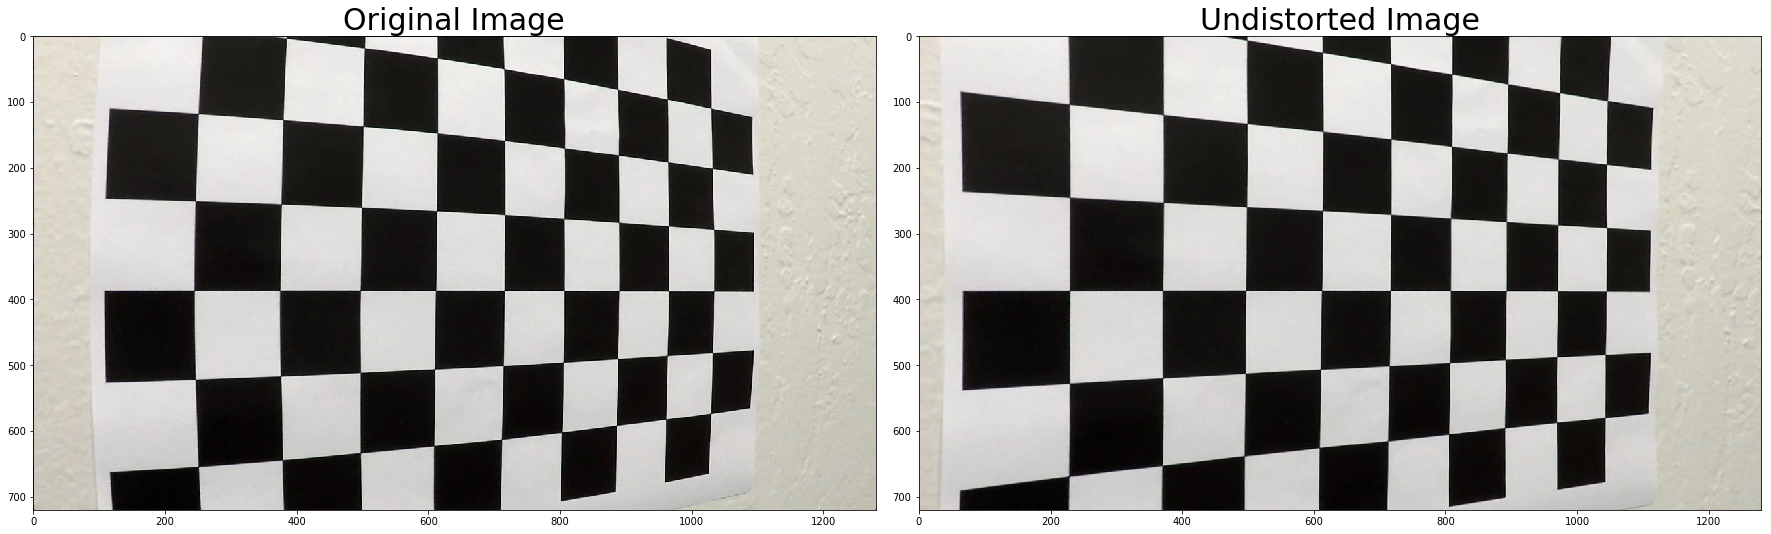

In [8]:
test_img = mpimg.imread(fnames[0])
undist = cv2.undistort(test_img, mtx, dist, None, mtx);
show_images(test_img, undist, title2='Undistorted Image')


## Pipeline (single images)

### Undistort image

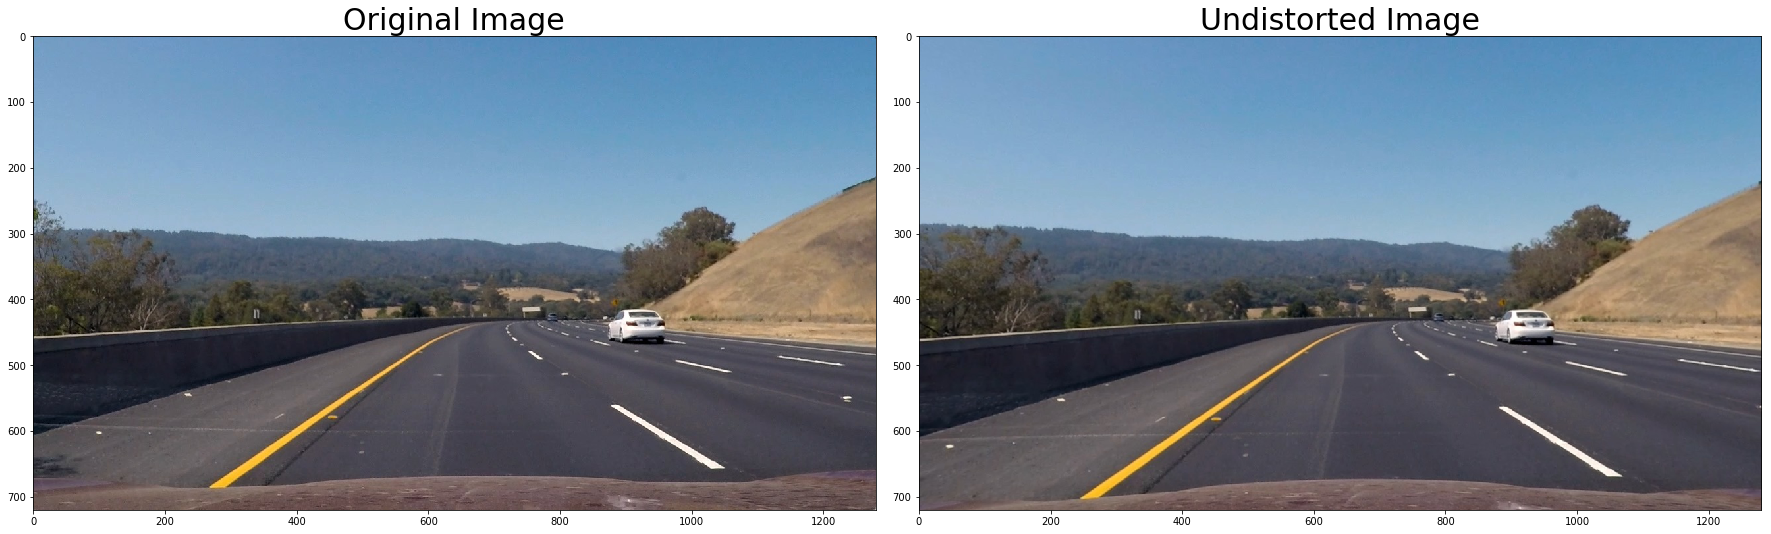

In [9]:
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist
test_img = mpimg.imread('test_images/test3.jpg')
undist = undistort(test_img)
show_images(test_img, undist, title2='Undistorted Image')

### Color Threshold
Explore test images in different color spaces, observe which makes the lane lines stand out.

In [10]:
def convert_color_space(img, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            new_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            new_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'LAB':
            new_image = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        elif color_space == 'HLS':
            new_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            new_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            new_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: new_image = np.copy(img) 
    return new_image

def show_color_spaces(img, color_spaces=['RGB', 'HSV', 'YUV', 'HLS', 'LUV', 'LAB'], cmap=None):
    
    for color in color_spaces:
        new_image = convert_color_space(img, color)
        f, axs = plt.subplots(1, 4, figsize=(16,3))
        axs = axs.ravel()
        for i in range(len(axs)):  
            axs[i].axis('off')
            if i == 0:
                axs[i].imshow(new_image)
            else:
                axs[i].imshow(new_image[:,:,i-1], cmap='gray')
            title = color if i == 0 else color[i-1] + ' Channel'
            axs[i].set_title(title)

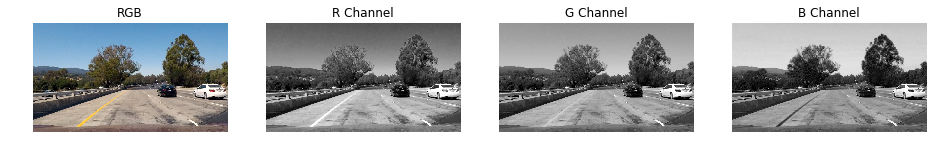

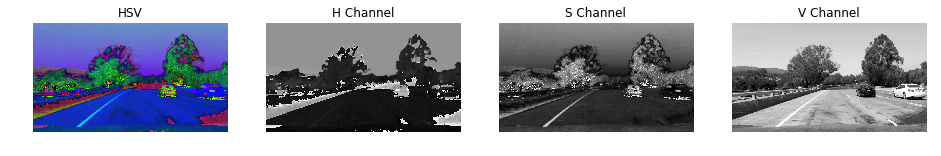

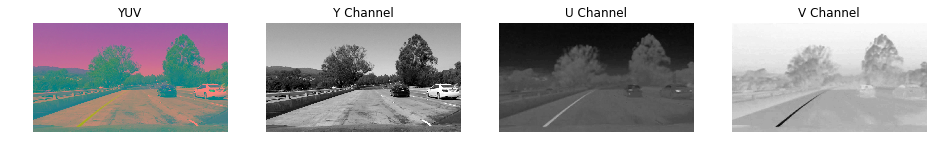

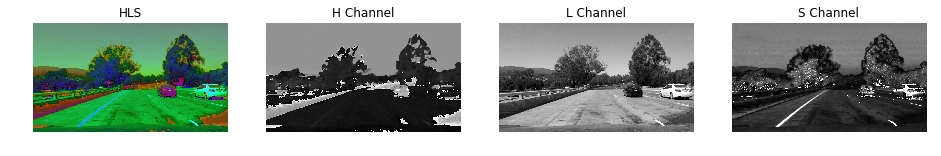

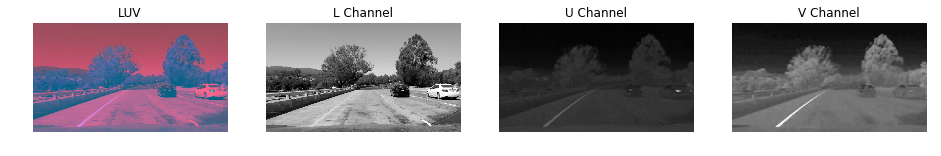

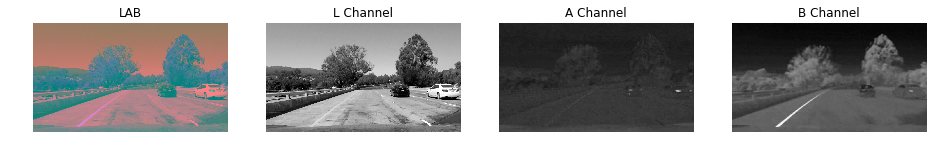

In [11]:
test_image = mpimg.imread('test_images/test1.jpg')
show_color_spaces(test_image)

In [12]:
def color_binary(img):
    hsv = convert_color_space(img, 'HSV')
    binary = np.zeros_like(hsv[:,:,0])
    
    YELLOW_MIN1 = np.array([0, 90, 200],np.uint8)
    YELLOW_MAX1 = np.array([50, 255, 255],np.uint8)
    yellow1 = cv2.inRange(hsv, YELLOW_MIN1, YELLOW_MAX1)
    
    # Identify yellow lane when there's reflection on windshield
    YELLOW_MIN2 = np.array([0, 21, 100],np.uint8)
    YELLOW_MAX2 = np.array([50, 81, 130],np.uint8)
    yellow2 = cv2.inRange(hsv, YELLOW_MIN2, YELLOW_MAX2)

    WHITE_MIN = np.array([0, 0, 210],np.uint8)
    WHITE_MAX = np.array([179, 70, 255],np.uint8)
    white = cv2.inRange(hsv, WHITE_MIN, WHITE_MAX)
    
    # Remove trees on roadside
    green = cv2.inRange(hsv, (30, 60, 100), (120, 255, 255))
    

    binary[((yellow1 == 255) | (yellow2 == 255) | (white == 255)) & (green==0)] = 1
    #binary[(yellow2 == 255)]=1
    return binary

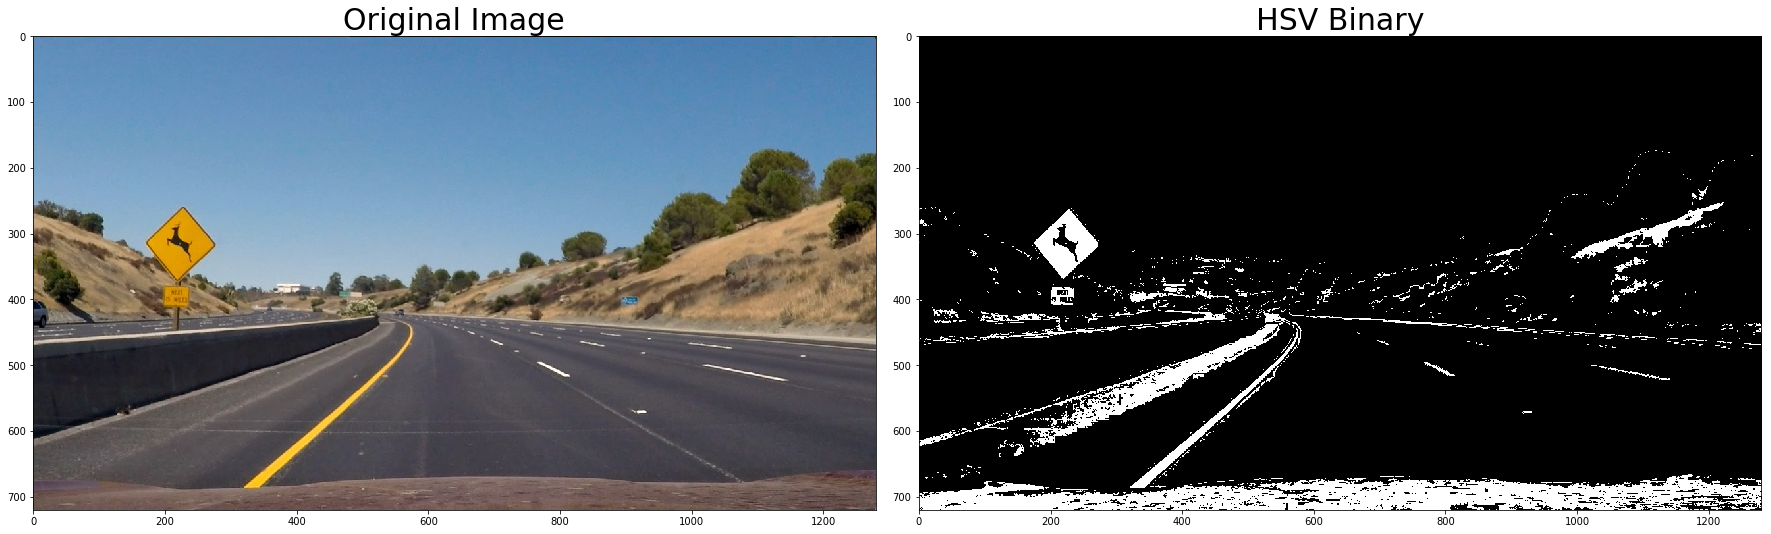

In [ ]:
image = mpimg.imread('test_images/test2.jpg')
s_binary = color_binary(image)
show_images(image, s_binary, title2='HSV Binary')

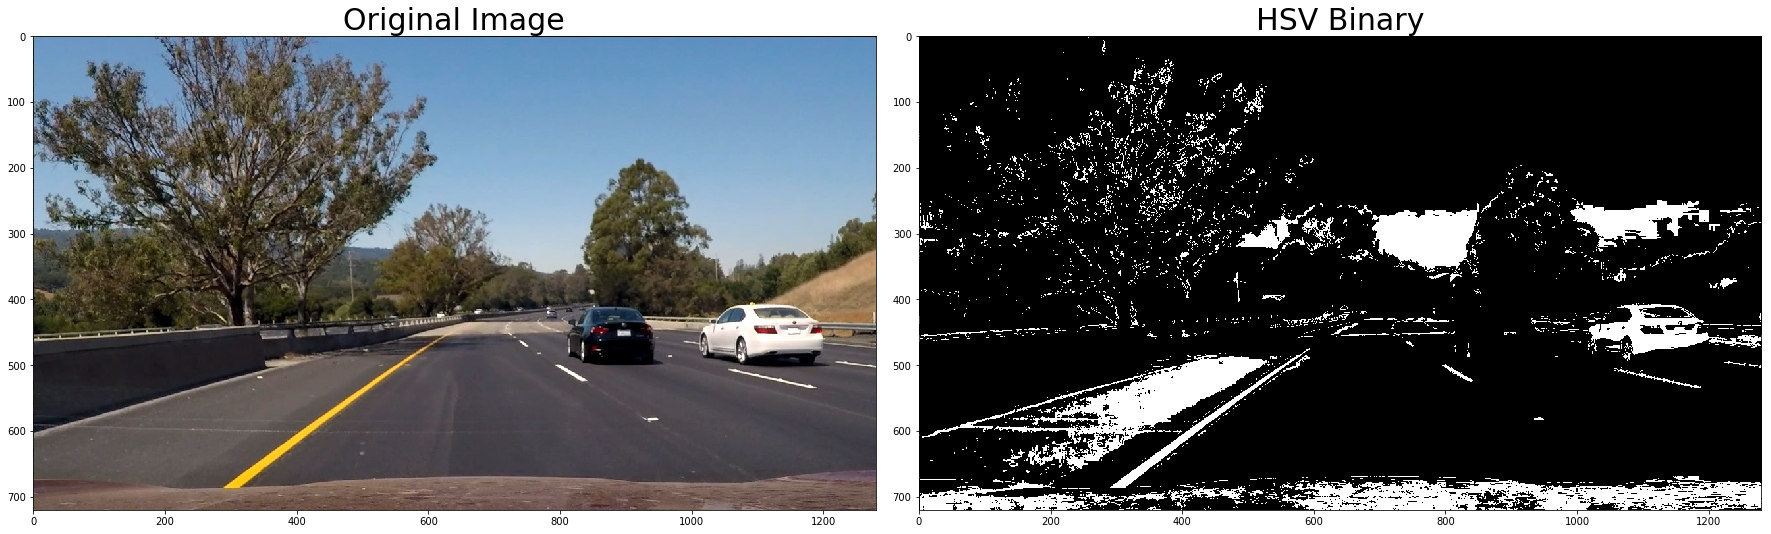

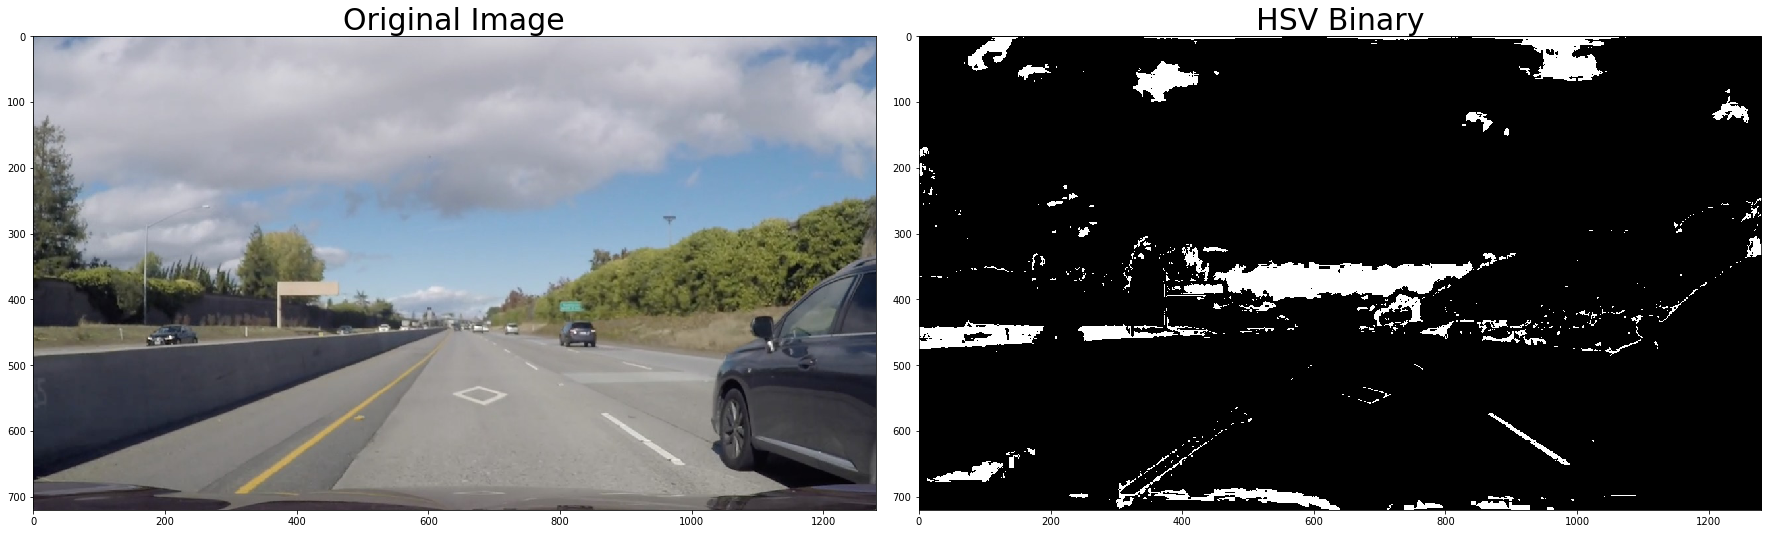

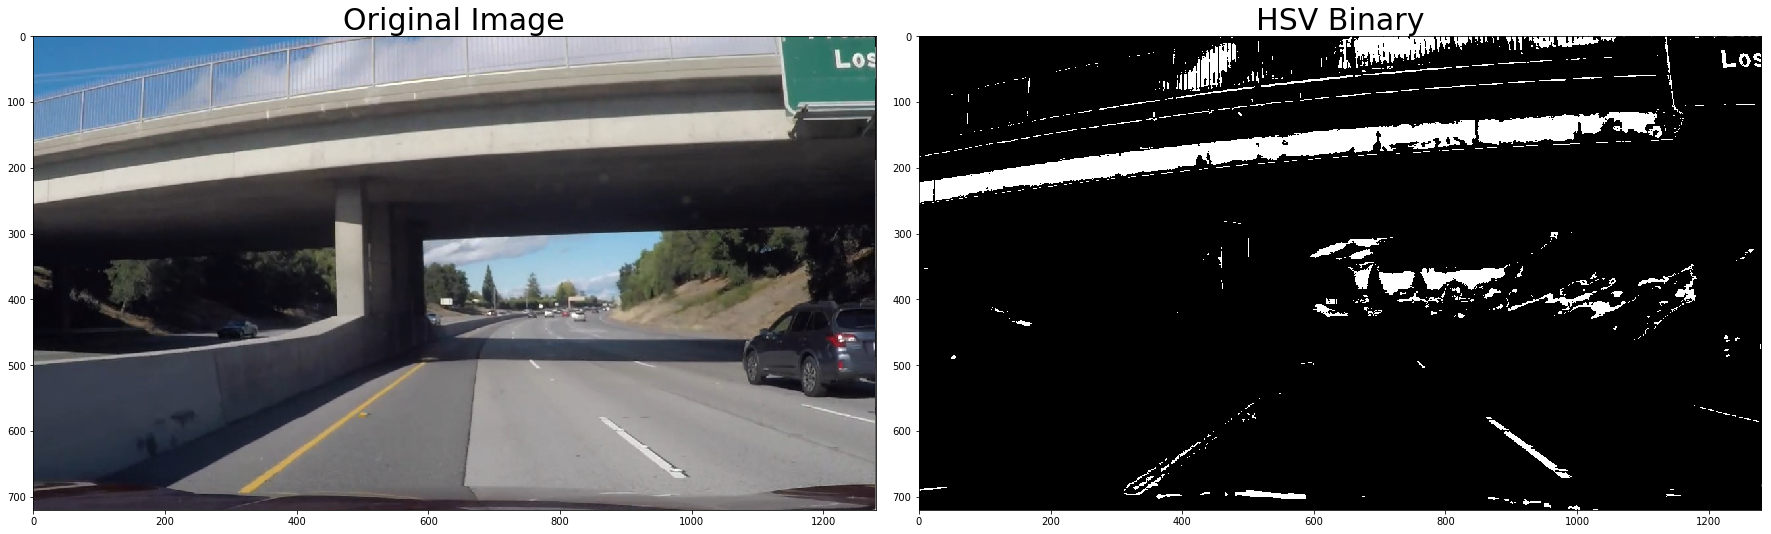

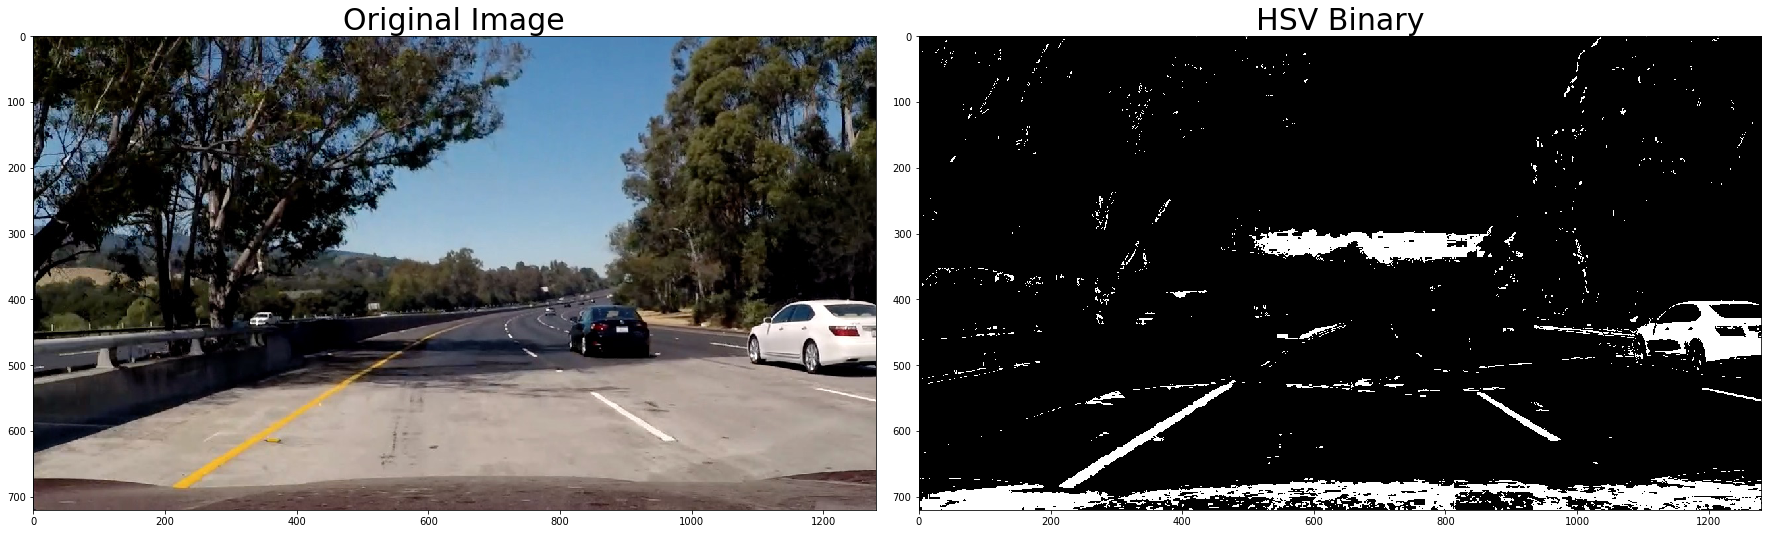

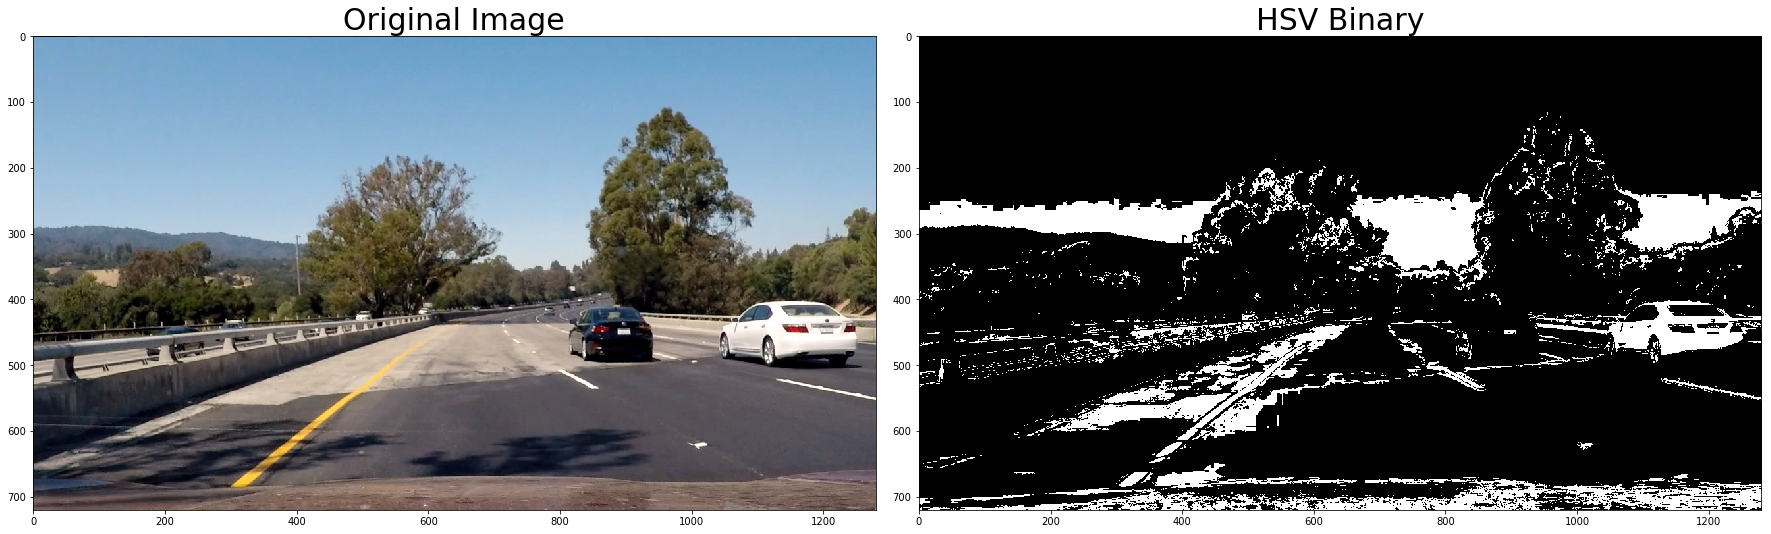

In [ ]:
test_fnames = glob.glob('test_images/test*.jpg')
for fname in test_fnames:
    image = mpimg.imread(fname)
    s_binary = color_binary(image)
    show_images(image, s_binary, title2='HSV Binary')

### Gradient Threshold

Explore the effects of sobel gradient in x direction, y direction, magnitude, or specific direction.

In [ ]:
def abs_sobel_thresh(channel, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        sobel = cv2.Sobel(channel, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(channel, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel>thresh[0]) & (scaled_sobel<thresh[1])] = 1
    return binary_output

In [ ]:
test_image = mpimg.imread('test_images/test7.jpg')
v_channel = convert_color_space(test_image, 'HSV')[:, :, 2]
v_binary = abs_sobel_thresh(v_channel, orient='x', thresh=(30, 200))
show_images(test_image, v_binary, title2='Thresholded Gradient - X')

In [ ]:
test_image = mpimg.imread('test_images/test3.jpg')
v_channel = convert_color_space(test_image, 'HSV')[:, :, 2]
v_binary = abs_sobel_thresh(v_channel, orient='y', thresh=(30, 200))
show_images(test_image, v_binary, title2='Thresholded Gradient - Y')

Y-gradient does a cleaner job for picking up the lane lines.

In [ ]:
def mag_thresh(channel, x_ksize=3, y_ksize=3, mag_thresh=(0, 255)):
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize=x_ksize)
    sobely = cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize=y_ksize)
    magnitude = (sobelx**2 + sobely**2)**.5
    scale_magnitude = np.uint8(255*magnitude/np.max(magnitude))
    binary_output = np.zeros_like(channel)
    binary_output[(scale_magnitude > mag_thresh[0]) & (scale_magnitude < mag_thresh[1])] = 1
    return binary_output

In [ ]:
test_image = mpimg.imread('test_images/test7.jpg')
v_channel = convert_color_space(test_image, 'HSV')[:,:,2]
mag_binary = mag_thresh(v_channel, x_ksize=3, y_ksize=7, mag_thresh=(30,200))
show_images(test_image, mag_binary, title2='Mag Binary - greater y kernel size')

In [ ]:
mag_binary = mag_thresh(v_channel, x_ksize=9, y_ksize=3, mag_thresh=(30,200))
show_images(test_image, mag_binary, title2='Mag Binary - greater x kernel size')

In [ ]:
def dir_threshold(channel, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    grad_direct = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(channel)
    binary_output[(grad_direct > thresh[0]) & (grad_direct < thresh[1])] = 1
    return binary_output

In [ ]:
test_image = mpimg.imread('test_images/test2.jpg')
v_channel = convert_color_space(test_image, 'HSV')[:,:,2]
dir_binary = dir_threshold(v_channel, sobel_kernel=3, thresh=(0.9, 1.1))
show_images(test_image, dir_binary, title2='(HS)V Directional Binary')

In [ ]:
def gradient_binary(img):
    hsv = convert_color_space(img, 'HSV')
    v_channel = hsv[:,:,2]
    v_mag_binary_y = mag_thresh(v_channel, x_ksize=3, y_ksize=7, mag_thresh=(30,200))
    v_mag_binary_x = mag_thresh(v_channel, x_ksize=13, y_ksize=3, mag_thresh=(30,200))
    binary = np.zeros_like(v_channel)
    binary[(v_mag_binary_y == 1) & (v_mag_binary_x == 1)] = 1
    return binary

In [ ]:
test_image = mpimg.imread('test_images/test7.jpg')
grad_binary = gradient_binary(test_image)
show_images(test_image, grad_binary, title2='Gradient Binary')

In [ ]:
def thresholded_binary(img):
    cbinary = color_binary(img)
    grad_binary = gradient_binary(img)
    combined_binary = np.zeros_like(cbinary)
    demo_binary = np.dstack(( combined_binary, cbinary, grad_binary)) * 255
    combined_binary[(cbinary == 1) | (grad_binary == 1)] = 1
    return demo_binary, combined_binary

In [ ]:
#test_image = mpimg.imread('test_images/test2.jpg')
demo_binary, thresh_binary = thresholded_binary(undist)
show_images(test_img, thresh_binary, title2='Combined color and gradient thresholds')

### Perspective Transform

In [ ]:
img_size = (test_image.shape[1], test_image.shape[0])
min_y = img_size[1] *2 / 3
max_y = img_size[1] * 0.9
src = np.float32(
         [[(img_size[0] / 2) - 89, min_y],
         [(img_size[0] * 297/1280), max_y],
         [(img_size[0] * 1001/1280), max_y],
         [(img_size[0] / 2 + 90), min_y]])
dst = np.float32(
         [[(img_size[0] / 4), 0],
         [(img_size[0] / 4), max_y],
         [(img_size[0] * 3 / 4), max_y],
         [(img_size[0] * 3 / 4), 0]])
# print(src)
# print(dst)

def warper(undist, img_size, src=src, dst=dst):

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undist, M, (img_size[1], img_size[0]))
    return warped, M, Minv

In [ ]:
straight_image = mpimg.imread('test_images/straight_lines1.jpg')
# undist = cv2.undistort(test_image, mtx, dist, None, mtx);
straight_image_copy = straight_image.copy()
cv2.polylines(straight_image_copy,np.array([src], np.int32),True,(255,0,0), thickness=3)
straight_top_down, perspective_M, Minv = warper(straight_image, undist.shape)
straight_top_down_copy = straight_top_down.copy()
cv2.polylines(straight_top_down, np.array([dst], np.int32),True,(255,0,0), thickness=3)
show_images(straight_image_copy, straight_top_down, title1='Undistorted image with source points drawn', title2='Warped result with dest. points drawn', fsize=30)

In [ ]:
top_down, perspective_M, Minv = warper(thresh_binary, img_size=thresh_binary.shape)
show_images(thresh_binary, top_down, title1='Undistorted image with source points drawn', title2='Warped result with dest. points drawn', fsize=30)

## Detect Lane Pixels

I now have a thresholded warped image. Next, I need to decide explicitly which pixels are part of the lines, and which belong to the left line and which belong to the right line.

I first take a histogram along all the columns in the lower half of the image like following:

In [ ]:
def x_bases(top_down_binary, plot=False):
    histogram = np.sum(top_down_binary[top_down_binary.shape[0]//2:int(top_down_binary.shape[0]*0.9),:], axis=0)
    
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    if plot:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 7))
        f.tight_layout()
        ax1.plot(histogram)
        ax1.set_title('Line Finding: Peaks in Histogram', fontsize=30)
        ax2.imshow(top_down_binary, cmap='gray')
        ax2.set_title('Warped result', fontsize=30)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return leftx_base, rightx_base

leftx_base, rightx_base = x_bases(top_down, plot=True)
print('left X base: {}, right X base: {}'.format(leftx_base, rightx_base))


In [ ]:
def nonzero(binary):
    nonzero = binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    return nonzeroy, nonzerox

def sliding_window(binary_warped, plot=False):
    # Choose the number of sliding windows
    nwindows = 12
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
#     nonzero = binary_warped.nonzero()
#     nonzeroy = np.array(nonzero[0])
#     nonzerox = np.array(nonzero[1])
    nonzeroy, nonzerox = nonzero(binary_warped)
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        if plot:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            if win_xright_high < binary_warped.shape[1] and win_xright_low > 0:
                cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
                (0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        if win_xright_high < binary_warped.shape[1] and win_xright_low > 0:
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        if win_xright_high < binary_warped.shape[1] and win_xright_low > 0:
            right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    return leftx, lefty, rightx, righty, out_img

def fit_lines(leftx, lefty, rightx, righty, out_img=None):
    
#     if len(leftx) == 0 or len(lefty) == 0 or len(rightx) == 0 or len(righty) == 0:
#         return None, None
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2) if (len(lefty)>0 and len(leftx)>0) else None
    right_fit = np.polyfit(righty, rightx, 2) if (len(righty)>0 and len(rightx)>0) else None
    
    if out_img is not None:
        #left_fit, right_fit = sliding_window(binary_warped)
        ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        plt.imshow(out_img)
        plt.rcParams["figure.figsize"] = (10,5)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit, right_fit

leftx, lefty, rightx, righty, out_img = sliding_window(top_down, plot=True)
left_fit, right_fit = fit_lines(leftx, lefty, rightx, righty, out_img=out_img)

In [ ]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image):
    
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching

    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

def plot_window_centroids(window_centroids, warped):
    window_width = 120 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    # Display the final results
    plt.imshow(output)
    plt.title('window fitting results')
    plt.show()
    
window_centroids = find_window_centroids(top_down)
plot_window_centroids(window_centroids, top_down)

Now I know where the lines are. For the next frame of video I don't need to do the blind search again, instead, I can just search in the margin around the preivous line position like this: 

In [ ]:
def look_ahead_search(binary_warped, left_fit, right_fit, plot=False):

    nonzeroy, nonzerox = nonzero(binary_warped)
    
    margin = 100
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    if plot:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    return leftx, lefty, rightx, righty

leftx, lefty, rightx, righty = look_ahead_search(top_down, left_fit=left_fit, right_fit=right_fit, plot=True)

## Determine the Curvature and Center Offset

In [ ]:
def get_curvature(left_fit, right_fit, y_eval):
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0]) if left_fit is not None else None
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0]) if right_fit is not None else None
    return left_curverad, right_curverad

left_fit, right_fit = fit_lines(leftx, lefty, rightx, righty)
left_curverad, right_curverad = get_curvature(left_fit, right_fit, top_down.shape[0])
print('curvature left: {} px, right: {} px'.format(left_curverad, right_curverad))

In [ ]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def get_world_curvature(leftx, lefty, rightx, righty, y_eval):
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad

left_curverad, right_curverad = get_world_curvature(leftx, lefty, rightx, righty, top_down.shape[0])
print('curvature left: {} m, right: {} m'.format(left_curverad, right_curverad))

In [ ]:
def get_base_poses(left_fit, right_fit, y_eval):
    left_base_pose = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_base_pose = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    return left_base_pose, right_base_pose

def get_center_offset(left_base_pose, right_base_pose, image_width):
    lane_center = (left_base_pose + right_base_pose) / 2 
    center_offset = (lane_center - image_width/2)*xm_per_pix
    return center_offset

left_base_pose, right_base_pose = get_base_poses(left_fit, right_fit, top_down.shape[0])
center_offset = get_center_offset(left_base_pose, right_base_pose, top_down.shape[1])
print('center offset {} m'.format(center_offset))

In [ ]:
def draw_curvature(image, left_curverad, right_curverad):
    new_image = np.copy(image)
    curverad = (left_curverad + right_curverad)/2
    cv2.putText(new_image, 'Radius of Curvature {:.0f}(m)'.format(curverad), (120,160),
            fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 3)
    return new_image

curve_image = draw_curvature(test_img, left_curverad, right_curverad)
plt.imshow(curve_image)

In [ ]:
def draw_offset(image, center_offset):
    new_image = np.copy(image)
    side = 'left' if center_offset < 0 else 'right'
    cv2.putText(new_image, 'Vehicle is {:.2f}m {} of center'.format(abs(center_offset), side), (100,80),
                     fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 4)
    return new_image
curve_offset_image = draw_offset(curve_image, center_offset)
plt.imshow(curve_offset_image)  

## Inverse Transform

In [ ]:
def map_lane(undist, warped, Minv, left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    if left_fit is not None and right_fit is not None:
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result


In [ ]:
#test_image = mpimg.imread('test_images/test3.jpg')
#undist = cv2.undistort(test_image, mtx, dist, None, mtx)
result = map_lane(undist, top_down, Minv, left_fit, right_fit)
result = draw_curvature(result, left_curverad, right_curverad)
result = draw_offset(result, center_offset)
plt.imshow(result)

## Build an Advanced Lane Finding Pipeline

Build the pipeline and run the solution on all test images. Make copies into the test_images_output directory.

In [ ]:
def pipeline(img):
    #1. Undistort
    undist = undistort(img)
    #2. Gradient thresholded binary
    _, thresholded = thresholded_binary(undist)
    #3. Warp to top down
    top_down, perspective_M, Minv = warper(thresholded, img.shape)
    #4. Search and fit polynomial lines
    leftx, lefty, rightx, righty, _ = sliding_window(top_down)
    left_fit, right_fit = fit_lines(leftx, lefty, rightx, righty)
    #5. Calculate curvature and center offset
    left_curverad, right_curverad = get_world_curvature(leftx, lefty, rightx, righty, top_down.shape[0])
    left_base_pose, right_base_pose = get_base_poses(left_fit, right_fit, top_down.shape[0])
    center_offset = get_center_offset(left_base_pose, right_base_pose, top_down.shape[1])
    #6. Draw the lane on image (and inverse transform)
    new_image = map_lane(undist, top_down, Minv, left_fit, right_fit)
    #7. Draw curvature and offset
    new_image = draw_curvature(new_image, left_curverad, right_curverad)
    new_image = draw_offset(new_image, center_offset)
    return new_image

In [ ]:
test_fnames = glob.glob('test_images/test*.jpg')
n_col = 4
n_row = int(np.ceil(len(test_fnames)/n_col))
f, axs = plt.subplots(n_row, n_col, figsize=(20,3*n_row))
axs = axs.ravel()
for i in range(len(axs)):
    if i < len(test_fnames):
        axs[i].axis('off')
        image = mpimg.imread(test_fnames[i])
        processed = pipeline(image)
        axs[i].imshow(processed)
    else:
        f.delaxes(axs[i])

Next, I'll run the pipeline on a video stream.

To do it, I had to keep track of things like where my last several detections of the lines were, and what the curvature was, so I could properly treat new detections. 

I defined a `Line()` class to keep track of all the parameters I measure from frame to frame.

In [ ]:
from collections import deque

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # polynomial coefficients for the last n fits of the line
        self.recent_fitted = deque(maxlen=3)  
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # number of failed detections
        self.num_undetected = 100

    
    def update_detected(self, line_fit, curvature, base_pose, linex, liney):
        self.detected = True
        self.diffs = line_fit - self.current_fit
        self.current_fit = np.array(line_fit)
        self.recent_fitted.append(line_fit)
        self.best_fit = sum(self.recent_fitted) / len(self.recent_fitted)
        self.radius_of_curvature = curvature
        self.line_base_pos = base_pose
        self.allx = linex
        self.ally = liney
        self.num_undetected = 0
    
    def update_undetected(self):
        self.detected = False
        self.num_undetected += 1

left_line = Line()
right_line = Line()

In [ ]:
# Sanity checks
def similar_curve(left_curve, right_curve):
    diff = np.linalg.norm(left_curve - right_curve)
    #print('curve diff {}, left {}, right {}'.format(diff, left_curve, right_curve))
    return diff < 5000

def right_distance(left_fit, right_fit):
    diff = np.linalg.norm(left_fit - right_fit)
    #print('distance diff {}'.format(diff))
    return diff < 820

def parallel(left_fit, right_fit):
    left_slope = 2*left_fit[0]
    right_slope = 2*right_fit[0]
    diff = np.linalg.norm(left_slope - right_slope)
    #print('slope diff {}, left {}, right {}'.format(diff, left_slope, right_slope))
    return diff < 8e-4

def good_frame(left_fit, right_fit, left_curve, right_curve):
    curve_good = similar_curve(left_curverad, right_curverad)
    distance_good = right_distance(left_fit, right_fit)
    slope_good = parallel(left_fit, right_fit)
    #print('detection ' + str(curve_good) + ', ' + str(distance_good) + ', ' + str(slope_good))
    return curve_good and distance_good and slope_good


In [ ]:
def video_pipeline(img):
    
    #1. Undistort
    undist = undistort(img)
    
    #2. Gradient thresholded binary
    _, thresholded = thresholded_binary(undist)
    
    #3. Warp to top down
    top_down, perspective_M, Minv = warper(thresholded, img.shape)
    
    #4. Search and fit polynomial lines
    if left_line.num_undetected > 3 or right_line.num_undetected > 3:
        leftx, lefty, rightx, righty, _ = sliding_window(top_down)
        left_fit, right_fit = fit_lines(leftx, lefty, rightx, righty)
    else:
        leftx, lefty, rightx, righty = look_ahead_search(top_down, left_fit=left_line.best_fit, right_fit=right_line.best_fit)
        left_fit, right_fit = fit_lines(leftx, lefty, rightx, righty)

    if left_fit is not None and right_fit is not None:
        #5. Calculate curvature and center offset
        left_curverad, right_curverad = get_world_curvature(leftx, lefty, rightx, righty, top_down.shape[0])
        left_base_pose, right_base_pose = get_base_poses(left_fit, right_fit, top_down.shape[0])

        # sanity check
        if good_frame(left_fit, right_fit, left_curverad, right_curverad):
            #print('good frame')
            left_line.update_detected(left_fit, left_curverad, left_base_pose, leftx, lefty)
            right_line.update_detected(right_fit, right_curverad, right_base_pose, rightx, righty)
        else:
            #print('undetected1')
            left_line.update_undetected()
            right_line.update_undetected()
    else:
        #print('undetected2')
        left_line.update_undetected()
        right_line.update_undetected()
    
    new_image = img
    if left_line.best_fit is not None and right_line.best_fit is not None:
        center_offset = get_center_offset(left_line.line_base_pos, right_line.line_base_pos, top_down.shape[1])

        #6. Draw the lane on image (and inverse transform)
        new_image = map_lane(undist, top_down, Minv, left_line.best_fit, right_line.best_fit)
        #7. Draw curvature and offset
        new_image = draw_curvature(new_image, left_line.radius_of_curvature, right_line.radius_of_curvature)
        new_image = draw_offset(new_image, center_offset)
    return new_image

In [ ]:
left_line = Line()
right_line = Line()
test_image = mpimg.imread('test_images/test7.jpg')
pipeline_result = video_pipeline(test_image)
plt.imshow(pipeline_result)

## Test on Videos

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def test_video(src_path, dst_path, subclip_range=None):
    global left_line, right_line
    left_line = Line()
    right_line = Line()
    
    project_output = dst_path        

    if subclip_range is None:
        clip1 = VideoFileClip(src_path)
    else:
        clip1 = VideoFileClip(src_path).subclip(subclip_range)
    white_clip = clip1.fl_image(video_pipeline)
    
    %time white_clip.write_videofile(project_output, audio=False)

In [ ]:
test_video('project_video.mp4','test_videos_output/project_video.mp4')

In [ ]:
test_video('challenge_video.mp4','test_videos_output/challenge_video.mp4')

In [ ]:
test_video('harder_challenge_video.mp4','test_videos_output/harder_challenge_video.mp4')